# Modeling Relationships

In this section, we’ll explore how to build complex relationships between entities using a combination of uniqueness constraints and referential constraints.

## Uniqueness Constraints

Uniqueness constraints are typically set through primary keys, but tables can also have additional unique indexes beyond the primary key.

## Referential Constraints

Referential constraints establish relationships between tables and are enforced by [foreign keys](030-foreign-keys.ipynb).

## Foreign Keys Establish 1:N or 1:1 Relationships

When a child table defines a foreign key constraint to a parent table, it creates a relationship between the entities in the parent and child tables. The cardinality of this relationship is always **1 on the parent side**: each entry in the child table must refer to a single entity in the parent table.

On the child side, the relationship can have different cardinalities:

- **0–1**: if the foreign key field in the child table has a unique constraint.
- **N**: if no uniqueness constraint is applied to the foreign key field.

Let’s illustrate these possibilities with examples of bank customers and their accounts.


In [14]:
import datajoint as dj

# One-to-Many Relationships

In the first example, let the rule be that customers are independent entities and accounts have exactly one owner but customers can have any number of accounts.
This is an example of an 1:N relationship between customers and their accounts.

Then the foreign key is declared in the `Account` table.

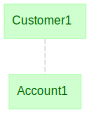

In [15]:
schema1 = dj.Schema('bank1')
@schema1
class Customer1(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned
    unique index(ssn)
    """

@schema1
class Account1(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> Customer1
    open_date : date
    """

dj.Diagram(schema1)

In this design:

* Each account is linked to a single customer through a foreign key referencing the primary key in Customer1, ensuring that each account has one, and only one, owner.
* This setup allows each customer to own multiple accounts, as there is no unique constraint on the foreign key in Account1.
* Customers may have zero or more accounts, as there’s no requirement for every customer to have an associated account.
* Every account must have an owner, since the foreign key reference to Customer1 is mandatory (non-nullable).

This structure establishes a one-to-many relationship between customers and accounts: one customer can own multiple accounts, but each account belongs to only one customer.

To allow some accounts without an assigned owner, we can modify the design to make the foreign key nullable:

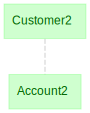

In [16]:
schema2 = dj.Schema('bank2')
@schema2
class Customer2(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned
    unique index(ssn)
    """

@schema2
class Account2(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> [nullable] Customer2
    open_date : date
    """

dj.Diagram(schema2)

In this modified design:

* Accounts without owners are allowed by setting the foreign key to Customer2 as nullable.
* The schema diagram does not visually distinguish between required and optional dependencies, so the nullable nature of the foreign key is not visible in the diagram.
* This configuration supports cases where accounts may or may not be assigned to a customer, adding flexibility to the data model.

Consider a third design where the foreign key is part of a composite primary key:

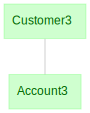

In [17]:
schema3 = dj.Schema('bank3')

@schema3
class Customer3(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema3
class Account3(dj.Manual):
    definition = """
    -> Customer3
    account : int unsigned
    ---
    open_date : date
    """

dj.Diagram(schema3)

In this design:

* Composite Primary Key: The primary key for `Account3` is a combination of `customer_id` and `account`, meaning each account is uniquely identified by both the customer and account number together and neither of the two fields separately has to be unique across accounts.
* One-to-Many Relationship: Since `customer_id` is only part of the primary key (not the entire primary key), it doesn’t need to be unique within `Account3`. This allows each customer to have multiple accounts, preserving the one-to-many relationship between Customer3 and Account3.
* Foreign Key Reference: The foreign key to `Customer3` establishes the relationship, ensuring that each entry in Account3 references a valid customer in Customer3.

This setup maintains the one-to-many relationship while allowing for each account to be uniquely identified by a combination of customer and account identifiers.

In the diagram, solid lines indicate a dependency where the foreign key is part of the primary key, signifying a stronger relationship than a secondary reference. This stronger relationship ensures that any foreign keys pointing to `Account3` will also transitively reference `Customer3`.

### Exercise: Analyzing Bank Design

Review the database design below and consider how this structure might reflect the bank’s operations.

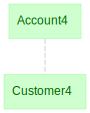

In [18]:
schema4 = dj.Schema('bank4')

@schema4
class Account4(dj.Manual):
    definition = """
    account : int unsigned
    ---
    open_date : date
    """


@schema4
class Customer4(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    -> Account4
    """


dj.Diagram(schema4)

### Interpretation
Consider the implications of this setup:

* Each customer entry contains a reference to a single account in `Account4`, suggesting that each customer is linked to one specific account.
* Since there is no constraint on the number of customers who can point to the same account, this design may allow multiple customers to be associated with a single account, indicating the possibility of shared accounts.
* However, the structure does not allow an customer to exist without being associated with an account, as each customer record must reference an existing account.

These choices might reflect the bank’s operations and policies, such as whether joint accounts are supported, and how account ownership is managed.

# One-to-One Relationships

A one-to-one relationship is created when a foreign key in the child table is also designated as either the primary key or a unique index. This ensures that each entry in the child table corresponds to a single, unique entry in the parent table, and no parent entry is linked to more than one child entry.

In a one-to-one relationship, the connection is always optional on the child side: a child entry is not required for every parent entry. Therefore, the cardinality on the child side is 0..1—each parent may have either zero or one associated child entry.

In the following example, the foreign key in `Account` is also its primary key, resulting in a one-to-one relationship:

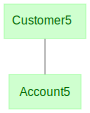

In [19]:
schema5 = dj.Schema('bank5')

@schema5
class Customer5(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema5
class Account5(dj.Manual):
    definition = """
    -> Customer5
    ---
    open_date : date
    """

dj.Diagram(schema5)

The diagramming notation represents this relationship with a thick solid line, which indicates the strongest type of dependency between two entities.
In this setup, `Customer5` and `Account5` share the same identity because `Account5` inherits its primary key from `Customer5`.
This setup creates a strict one-to-one relationship between Customer5 and Account5, where each account is uniquely and exclusively linked to a single customer.

### Characteristics of This Structure
* **Unified Identity:** Since `Account5` shares the primary key with `Customer5`, each `Account5` record is uniquely identified by the same key as `Customer5`.
This enforces the rule that each account cannot exist without an associated customer.

* **Conflated Entities:** In the diagram, the name `Account5` is no longer underscored, indicating it has ceased to function as a separate “dimension” or independent entity. `Account5` is now fully conflated with `Customer5`, meaning it effectively serves as an extension of the `Customer5` entity, rather than an independent table with its own identity.

### Why Keep Separate Tables?
Although this design could allow us to simply merge all account-related data into the `Customer5` table, there are reasons we may choose to keep `Account5` as a separate table:

1. **Modularity and Clarity**: Separating `Account5` from `Customer5` keeps the structure modular, which can clarify different aspects of customer and account data in queries and during development.

2. **Data Management**: By keeping account information in a separate table, we can manage and update account-related data independently from customer information. This separation can be beneficial for tasks such as auditing, logging, or updating fields associated with only account data.

3. **Avoiding Optional Fields**: In cases where certain fields are only relevant to accounts (e.g., open_date, account-specific details), keeping them in a separate table prevents having unused or irrelevant fields in the main `Customer5` table.

4. **Access Control**: When account information is sensitive or needs restricted access, placing it in a separate table can simplify access control, allowing finer-grained security policies around account data.

5. **Scalability and Maintenance**: Over time, this separation can support scalability as customer and account data expand. If we anticipate adding extensive account-specific data or if account records will be managed differently from customer records, the separate tables facilitate maintenance and future-proof the structure.

6. **Schema Evolution**: Separate tables provide flexibility to adapt or expand either the Customer5 or Account5 table independently, without altering the other table. This flexibility is especially useful if the schema is expected to evolve over time.

Another approach to establishing a one-to-one relationship is to use a secondary foreign key with an additional uniqueness constraint. DataJoint’s foreign key syntax supports both `unique` and `nullable` modifiers on foreign keys, providing flexibility in how relationships are structured.

* **`unique` Modifier**: Adding the unique modifier to a foreign key converts a one-to-many relationship into a one-to-one relationship. This ensures that each entry in the child table corresponds to only one entry in the parent table and vice versa, enforcing a strict one-to-one link.

* **`nullable` Modifier**: The `nullable` modifier allows the relationship to be optional on the child side, meaning that not every child entry must reference a parent entry. (Relationships are already optional on the parent side, as parent entries don’t depend on children.)

## One-to-One Relationship with Unique and Nullable Modifiers
The following example demonstrates how to model a one-to-one relationship using a secondary unique constraint:

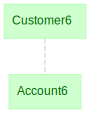

In [20]:

schema6 = dj.Schema('bank6')

@schema6
class Customer6(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema6
class Account6(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> [unique, nullable] Customer6
    open_date : date
    """

dj.Diagram(schema6)

In this design:

* The `Account6` table includes a foreign key reference to `Customer6`, modified with both `unique` and `nullable` modifications.
* The `unique` constraint ensures that each `Account6` entry is exclusively linked to a single `Customer6` entry, establishing a one-to-one relationship.
* The `nullable` constraint allows accounts to exist without necessarily being tied to a customer, making the relationship optional from the child’s perspective.


### When to Use this Approach
Using a secondary unique constraint on a foreign key is helpful when:

* **Optional Relationships**: You want flexibility to create child entries without always requiring a parent reference.
* **Separate, Modular Tables**: Keeping entities modular and maintaining a strict one-to-one relationship without merging the tables or merging the entity identities in the child table with those in the parent.

This method provides flexibility and maintains clear separation between entities while enforcing a one-to-one association, even if the relationship isn’t visually highlighted in the diagram.

## Diagram Representation Limitations

This *dependency-and-constraint* pattern doesn’t visually convey the close, exclusive association created by the unique and nullable modifiers. The diagram will show a basic line for the foreign key, lacking any specific notation to indicate that the relationship is both unique and optional.

The diagram only reflect the relationships formed through the the structure of primary keys and foreign keys, without taking into account the additional constraints imposed by secondary unique indexes. While solid think lines indicate a one-to-one relationship, additional uniqueness constraints may be in force that are not evident from the diagram alone.

Consider all the diagrams side-by-side and recall which ones are one-to-one and which are one-to-many:

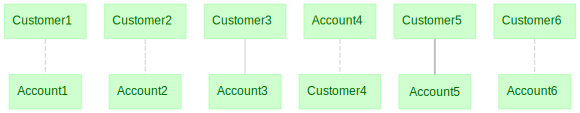

In [21]:
dj.Diagram(schema1) + dj.Diagram(schema2) + dj.Diagram(schema3) + dj.Diagram(schema4) + dj.Diagram(schema5) + dj.Diagram(schema6)

By examining the diagrams alone, only one (`schema5`) clearly shows a one-to-one relationship. For the others, additional constraints may modify the relationships, though these may not be immediately visible. In Jupyter, you can hover over a diagram element to view its full definition, including any secondary uniqueness constraints.

In practice, DataJoint users generally avoid secondary unique constraints when the primary key can enforce uniqueness. This approach has the added benefit of making relationships more transparent in the diagrams, providing a clearer representation of the schema’s structure.

# Many-to-Many Relationships

In relational databases, a single foreign key between two tables can only establish one-to-many or one-to-one relationships.
To create a many-to-many (M:N) relationship between two entities, a third table is required, with each entry in this table linking one instance from each of the two related tables.
This third table is commonly referred to as an association table or join table.

## Structure of Many-to-Many Relationships
An M:N relationship can be visualized as two one-to-many (1:N and 1:M) relationships with the association table.

The association table contains:
* **A foreign key** referencing each of the two related entities, establishing connections to instances of both tables.
* **Composite primary** key or a secondary unique constraint on the two foreign keys to ensure each combination of entities is unique.

This structure allows each entity to link to multiple instances of the other entity through the association table.

## Example: Bank Customers and Bank Accounts
Consider a bank system where customers can have multiple accounts, and accounts can be jointly owned by multiple customers. To represent this many-to-many relationship, an association table is used to link `Customer` and `Account`:

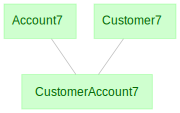

In [22]:
schema7 = dj.Schema('bank7')

@schema7
class Customer7(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    """

@schema7
class Account7(dj.Manual):
    definition = """
    account_id : int unsigned
    ---
    open_date : date
    """

@schema7
class CustomerAccount7(dj.Manual):
    definition = """
    -> Customer7
    -> Account7
    """

dj.Diagram(schema7)

DataJoint’s diagramming language does not use special notation for association tables; they appear identical to other tables.
By contrast, other diagramming styles, such as **Chen’s Entity-Relationship (ER) notation**, represent associations—often called "relationship sets"—with diamond shapes to distinguish them from entity sets.

DataJoint purposefully avoids this strict conceptual distinction between entities and relationships, as the boundary between them is often blurred.
For instance, a synapse between two neurons could be considered an entity, storing specific data about the synapse itself, or it might be viewed as an association linking two neurons.
Additionally, some relationships can even link other relationships, a complexity not easily captured in Chen’s notation.

In DataJoint, you can often recognize an association table by its converging pattern of foreign keys, which reference multiple tables to form a many-to-many relationship. This flexible approach supports various interpretations of relationships, making DataJoint schemas particularly adaptable for complex scientific data, where associations may themselves hold meaningful attributes.

Association tables are primarily used to establish many-to-many relationships, but they also offer the flexibility to model one-to-many and even one-to-one relationships by applying additional uniqueness constraints. By controlling the uniqueness on the foreign keys within the association table, you can fine-tune the type of relationship between entities.

### Example, enforcing One-to-Many with Shared Accounts 

In the following example, we model a scenario where each customer can have only one account, but each account may be shared among multiple customers.
This structure enforces a one-to-many relationship between `Customer8` and `Account8` via the `CustomerAccount8` association table.

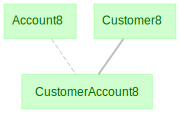

In [23]:
schema8 = dj.Schema('bank8')

@schema8
class Customer8(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    """

@schema8
class Account8(dj.Manual):
    definition = """
    account_id : int unsigned
    ---
    open_date : date
    """

@schema8
class CustomerAccount8(dj.Manual):
    definition = """
    -> Customer8
    ---
    -> Account8
    """

dj.Diagram(schema8)

### Explanation of the Design
* **Association Table (`CustomerAccount8`)**: The `CustomerAccount8` association table links `Customer8` and `Account8` through foreign keys. Although it resembles a many-to-many structure, by making the foreign key `-> Customer8` unique (it's the primary key), we ensure that each customer is associated with only one account. However, we leave the `-> Account8` foreign key unconstrained, allowing multiple customers to link to the same account, which enables account sharing.

## Versatility of Association Tables
While association tables are necessary for modeling many-to-many relationships, they can also model one-to-many and even one-to-one relationships.

This is accomplished by by altering their primary key or adding additional uniqueness constraints. If the association table links tables `A` and `B`, then:

* One-to-Many: 

```
-> B
--- 
-> A
```

Any number of `B`s are each matched to at most one `A`.


* One-to-One: 
```
-> A
---
-> [unique] B
```

With uniqueness constraints on both `A` and `B`, each entry in `A` is matched to at most one entry in `B` and vice versa.

* Many-to-Many

```
-> A
-> B
---
```
 Leave both foreign keys in the primary key, allowing each entity to associate freely with multiple instances of the other.

This approach makes association tables a powerful tool for defining relationships of varying cardinality, adding flexibility and adaptability to DataJoint schemas. By managing uniqueness constraints directly in the association table, you can model complex relationships while keeping the primary entities’ structures simple and intuitive.

The schema diagram indicates the cardinality of these associations with thick lines corresponding to one-to-one relationship and thin lines indicating one-to-many:

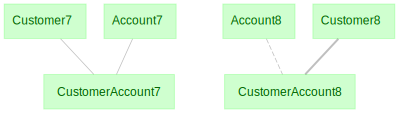

In [24]:
dj.Diagram(schema7) + dj.Diagram(schema8)

# More Design Patterns

Here we will consider several other common patterns that make use of uniqueness constraints (primary keys and unique indexes) and referential constraints (foreign keys) to design more complex relationships.

## Sequences

DataJoint schemas are directional: dependencies form a *directed-acyclic graph* (DAG) representing sequences of steps or operations.
The diagrams are plotted with all the dependencies pointing in the same direction (top-to-bottom or left-to-right), so that a schema diagram can be understood as an operational workflow.

Let's model a simple sequence of operations such as placing an order, shipping, and delivery.
The three entities: `Order`, `Shipment`, and `Delivery` form a sequence of one-to-one relationships:

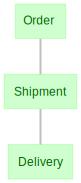

In [25]:
schema = dj.Schema('orders')

@schema
class Order(dj.Manual):
    definition = """
    order_number : int
    ---
    order_date : date
    """

@schema
class Shipment(dj.Manual):
    definition = """
    -> Order
    ---
    ship_date : date
    """


@schema
class Delivery(dj.Manual):
    definition = """
    -> Shipment
    ---
    delivery_date : date
    """

dj.Diagram(schema)

In this design, `Order`, `Shipment`, and `Delivery` use the same primary key that cascades through the sequence. This makes it straightforward to perform relationonal operations that skip steps. For example, joining information from `Order` and `Delivery` does not require the inclusion of `Shipment` in the query: `Order * Delivery` is a well-formed query:

In [27]:
Order * Delivery

order_number,order_date,delivery_date


## Hieararchies

Several 1:N relationships in sequence form a *hierachy*. Many data standards are defined as hierarchies.

Filesystems of files and folders with standardized naming conventions are examples of hiearchical structures.  Many file formats such as HDF5 are also hiearchical.

### Example: Brain Imaging Database 

Consider the hierarchical structure of the *[Brain Imaging Data Standard](https://bids.neuroimaging.io/)* — [@10.1038/sdata.2016.44], which is used for brain imaging data.

In BIDS, a neuroimaging study is organized around experiment subjects, imaging sessions for each subject, and then specific types of brain scans within each sessios: anatomical scans, diffusion-weighted imaging (DWI) scans, and functional imaging.
`Study`, `Subject`, `Session`, `Scan` form a hierarchical relationship.

Let's design a relational schema for the BIDS hiearchical format:

In [ ]:
schema = dj.Schema('bids')

@schema
class Study(dj.Manual):
    definition = """
    study : varchar(6)  # study unique code
    ---
    investigator : varchar(60)  # primary investigator
    study_description : varchar(255)
    """

@schema
class Study(dj.Manual):
    definition = """
    study : varchar(6)  # study unique code
    ---
    investigator : varchar(60)  # primary investigator
    study_description : varchar(255)
    """

@schema
class Subject(dj.Manual):
    definition = """
    -> Study
    subject_id  : varchar(8)
    ---  
    subject_species : enum('human', 'primate', 'rodent')
    date_of_birth = null : date
    subject_notes : varchar(2000)
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Session
    session  : smallint unsigned
    ---  
    session_date : date
    operator : varchar(60)
    aim : varchar(60)
    """

@schema
class Func(dj.Manual):
    definition = """
    -> Session
    func  : smallint unsigned
    ---  
    session_date : date
    operator : varchar(60)
    aim : varchar(60)
    """

# Design Patterns

- Sequence
  * workflows
- Specialization / Generalization
  * student / faculty / staff
- Hierarchies
  * Ownership
  * Using composite primary keys
  * Secondary keys
- Parameterization
  * 
- Associations
  * Many-to-many relationships
  * Directed graphs 
  * Trees
  * Undirected graphs
- Master-part


In [ ]:
import datajoint as dj

In [ ]:
schema = dj.schema("dimitri_patterns")
schema.drop()
schema = dj.schema("dimitri_patterns")

# Sequence / Workflows

In [ ]:
# E.g. order / shipment / confirmation

In [ ]:
@schema
class Order(dj.Manual):
    definition = """
    order_number : int
    ---
    order_date : date
    """

In [ ]:
@schema
class Shipment(dj.Manual):
    definition = """
    -> Order
    ---
    ship_date : date
    """

In [ ]:
@schema
class Confirm(dj.Manual):
    definition = """
    -> Shipment
    ---
    confirm_date : date
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
Order * Shipment * Confirm

In [ ]:
@schema
class Order2(dj.Manual):
    definition = """
    order_number : int
    ---
    order_date : date
    """


@schema
class Shipment2(dj.Manual):
    definition = """
    shipment_id : int
    ---
    ->[unique] Order2
    ship_date : date
    """


@schema
class Confirm2(dj.Manual):
    definition = """
    confirm_id : int
    ---
    -> [unique] Shipment2
    confirm_date : date
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
Order * Confirm

In [ ]:
Order * Shipment * Confirm

# Two ways to model hierarchies

## Approach 1: Simple primary keys with secondary dependencies

In [ ]:
@schema
class Subject(dj.Manual):
    definition = """
    # Experiment Subject
    subject_id : int
    ---
    species = 'mouse' : enum('human', 'mouse', 'rat', 'worm')
    sex : enum('F', 'M', 'unknown')
    """

In [ ]:
Subject()

In [ ]:
Subject.insert1(
    dict(subject_id=1, species="human", sex="unknown"), skip_duplicates=True
)
Subject.insert1(dict(subject_id=2, species="mouse", sex="F"), skip_duplicates=True)
Subject.insert1(dict(subject_id=3, species="worm", sex="M"), skip_duplicates=True)

In [ ]:
@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session : int
    ---
    session_timestamp = CURRENT_TIMESTAMP : timestamp
    """

In [ ]:
Session.insert1(dict(session=1, subject_id=2), skip_duplicates=True)
Session.insert1(dict(session=2, subject_id=2), skip_duplicates=True)
Session.insert1(dict(session=3, subject_id=3), skip_duplicates=True)

In [ ]:
Session()

In [ ]:
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_id : int
    ---
    laser_power : float  # mW
    """

In [ ]:
Scan()

In [ ]:
Scan.insert1(dict(subject_id=2, scan_id=1, session=1, laser_power=3200))

In [ ]:
@schema
class Cell(dj.Manual):
    definition = """
    -> Scan
    cell_id : int
    ---
    cell_type : enum('E', 'I')   # excitatory or inhibitory
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
# Give me excitatory cells for all males

In [ ]:
Cell & (Subject & {"sex": "M"})

In [ ]:
@schema
class Subject2(dj.Manual):
    definition = """
    # Experiment Subject
    subject_id : int
    ---
    species = 'mouse' : enum('human', 'mouse', 'rat', 'worm')
    sex : enum('F', 'M', 'unknown')
    """


@schema
class Session2(dj.Manual):
    definition = """
    session : int
    ---
    -> Subject2
    session_timestamp = CURRENT_TIMESTAMP : timestamp
    """


@schema
class Scan2(dj.Manual):
    definition = """
    scan_id : int
    ---
    -> Session2
    laser_power : float  # mW
    """


@schema
class Cell2(dj.Manual):
    definition = """
    cell_id : int
    ---
    -> Scan2
    cell_type : enum('E', 'I')   # excitatory or inhibitory
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
Cell.insert1(dict(cell_id=1, scan_id=1, cell_type="E"))

In [ ]:
Cell()

In [ ]:
# Give me cells for subject_id=1

Cell2 & (Scan2 & (Session2 & "subject_id=2"))

In [ ]:
# Give me cells for all males

(Cell2 & (Scan2 & (Session2 & (Subject2 & 'sex="M"')))).make_sql()

In [ ]:
(Cell & (Subject & 'sex="M"')).make_sql()

In [ ]:
dj.Diagram(schema)

# Parameterization

In [ ]:
@schema
class Image(dj.Manual):
    definition = """
    image_id : int
    ---
    image : longblob
    """

In [ ]:
@schema
class EnhanceMethod(dj.Lookup):
    definition = """
    enhance_method : int
    ---
    method_name : varchar(16)
    """

    contents = ((1, "sharpen"), (2, "contrast"))

In [ ]:
@schema
class EnhancedImage(dj.Manual):
    definition = """
    -> Image
    -> EnhanceMethod
    ---
    enhanced_image : longblob
    """

In [ ]:
dj.Diagram(schema)

# Association 

Books and authors

Checking accounts and account owners

In [ ]:
@schema
class Book(dj.Manual):
    definition = """
    isbn : int
    ---
    title : varchar(300)
    """

In [ ]:
@schema
class Author(dj.Manual):
    definition = """
    author_id : int
    ---
    name : varchar(300)
    """

In [ ]:
@schema
class AuthorBook(dj.Manual):
    definition = """
    -> Author
    -> Book
    ---
    order : tinyint unsigned 
    unique index(isbn, order)
    """

In [ ]:
dj.Diagram(schema)

# Generalization / specialization

Employee, student, instructor

In [ ]:
@schema
class Person(dj.Manual):
    definition = """
    person_id : int
    ---
    date_of_birth : date
    gender : enum("male", "female", "unknown")
    """

In [ ]:
@schema
class Employee(dj.Manual):
    definition = """
    -> Person
    ---
    hire_date : date    
    """


@schema
class Instructor(dj.Manual):
    definition = """
    -> Employee
    ---
    department : varchar(30)
    """


@schema
class Student(dj.Manual):
    definition = """
    -> Person
    ---
    admission_date : date
    """

In [ ]:
dj.Diagram(schema)

# Directed graphs 

In [ ]:
@schema
class Subordinate(dj.Manual):
    definition = """
    -> Employee
    ---
    -> Employee.proj(manager_id="person_id")
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
@schema
class Neuron(dj.Manual):
    definition = """
    neuron : int
    """


@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int
    ---
    -> Neuron.proj(pre="neuron")
    -> Neuron.proj(post="neuron")    
    """

In [ ]:
dj.Diagram(schema)

```sql

CREATE TABLE managed_by (
   person_id : int NOT NULL,
   manager_id : int NOT NULL,
   
   PRIMARY KEY (person_id),
   
   FOREIGN KEY (person_id) REFERENCES employee (person_id),
   FOREIGN KEY (manager_id) reference employee (person_id))
   

# Undirected graphs

In [ ]:
# direcated friendship = full directed graph capability
@schema
class Friendship(dj.Manual):
    definition = """
    -> Person.proj(friend1 = "person_id")
    -> Person.proj(friend2 = "person_id")
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
@schema
class Order(dj.Manual):
    definition = """
    order_id : int
    ---
    order_date : date
    """

    class Item(dj.Part):
        definition = """
        -> master
        order_item : int
        ---
        
        """

# Puzzle: 
Cities and states.
1. Each city belongs to one state. 
2. Each state has one capital.
3. A capital is a city.
4. A capital must be in the same state. 

* Tables
* Primary keys
* Foreign keys

In [ ]:
@schema
class State(dj.Manual):
    definition = """
    st : char(2)
    ---
    state : varchar(30)
    """


State.insert(
    (("WA", "Washington"), ("TX", "Texas"), ("AK", "Alaska"), ("LA", "Louisiana"))
)

In [ ]:
@schema
class City(dj.Manual):
    definition = """
    -> State
    city_name : varchar(30)
    ---
    capital = null : enum("YES")
    unique index(st, capital)
    """

In [ ]:
City.delete_quick()

City.insert1(("WA", "Seattle", None))
City.insert1(("TX", "Austin", "YES"))
City.insert1(("TX", "Houston", None))
City.insert1(("WA", "Olympia", "YES"))

In [ ]:
City()

In [ ]:
@schema
class State2(dj.Manual):
    definition = """
    state : char (2)
    ---
    state_name : varchar(30)
    """


@schema
class City2(dj.Manual):
    definition = """
    -> State2
    city_name : varchar(30)
    """


@schema
class Capital2(dj.Manual):
    definition = """
    -> State2
    ---
    -> City2
    """

In [ ]:
State2.delete_quick()
City2.delete_quick()

State2.insert(
    (("WA", "Washington"), ("TX", "Texas"), ("AK", "Alaska"), ("LA", "Louisiana"))
)

City2.insert1(("WA", "Seattle"))
City2.insert1(("TX", "Austin"))
City2.insert1(("TX", "Houston"))
City2.insert1(("WA", "Olympia"))

In [ ]:
dj.Diagram(schema)

In [ ]:
Capital2.insert1(("TX", "Austin"))

In [ ]:
Capital2.insert1(("TX", "Houston"))

In [ ]:
City2()

# In SQL 

```sql
CREATE TABLE state (
    state char(2) NOT NULL,
    state_name varchar(30) NOT NULL,
    PRIMARY KEY (state))
    
CREATE TABLE city (
    state char(2) NOT NULL,
    city_name varchar(30) NOT NULL,
    PRIMARY KEY (state, city_name),
    FOREIGN KEY (state) REFERENCES state(state))

CREATE TABLE capital (
    state char(2) NOT NULL,
    city_name varchar(30) NOT NULL,
    PRIMARY KEY (state),
    FOREIGN KEY (state, city_name) REFERENCES city (state, city_name))
```



```sql
CREATE TABLE state (
    state char(2),
    state_name varchar(30),
    capital varchar(30),
    PRIMARY KEY (state),
    FOREIGN KEY (state, capital) REFERENCES city (state, city_name))
    
CREATE TABLE city (
    state char(2),
    city_name varchar(30),
    PRIMARY KEY (state, city_name))
    FOREIGN KEY (state) REFERENCES state(state)
```

# In SQL 

```sql
CREATE TABLE state (
    state char(2) NOT NULL,
    state_name varchar(30) NOT NULL,
    PRIMARY KEY (state))
    
CREATE TABLE city (
    city_id int NOT NULL,
    state char(2) NOT NULL,
    city_name varchar(30) NOT NULL,
    is_capital enum('yes'),
    PRIMARY KEY (state_id),
    UNIQUE INDEX(state, is_capital),
    FOREIGN KEY (state) REFERENCES state(state))
```



## Problem 

Model a vet clinic. 

1. Customers bring in pets. Customers are identified by their cell phones. Pets are identified by their nicknames for that customer.

2. Pets have a date of birth, species, and date of birth.

3. Pets have a list of vaccinations that must be performed for their species.

4. Pets have vaccination administration, shot date. 

In [ ]:
schema = dj.Schema("shared_vet")
schema.drop()
schema = dj.Schema("shared_vet")

In [ ]:
@schema
class Owner(dj.Manual):
    definition = """
    cell_phone : char(10) 
    ---
    full_name : varchar(16)
    """

In [ ]:
@schema
class Species(dj.Lookup):
    definition = """
    species : varchar(30)
    """
    contents = (("cat",), ("dog",), ("ferret",), ("parrot",))

In [ ]:
Species()

In [ ]:
@schema
class Pet(dj.Manual):
    definition = """
    -> Owner
    -> Species
    nickname : varchar(30)
    ---
    birthdate : date
    """

In [ ]:
@schema
class RequiredVaccine(dj.Manual):
    definition = """
    -> Species
    vaccine  : varchar(10)
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
@schema
class Shot(dj.Manual):
    definition = """
    -> Pet
    -> RequiredVaccine
    ---
    shot_date : date
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
Shot()

```sql
create table shot (
    cell_phone char(10) NOT NULL,
    nickname varchar(16) NOT NULL,
    species varchar(20) NOT NULL,
    vaccine varchar(10) NOT NULL,
    PRIMARY KEY (cell_phone, nickname, species, vaccine),
    FOREIGN KEY (cell_phone, nickname, species) REFERENCES                         pet(cell_phone, nickname, species),
    FOREIGN KEY (species, vaccine) REFERENCES required_vaccine(species, vaccine)
)
```

## Homework homework

Homework assignments, students, grades

1. Homework is given with a due date.
2. Students submit homework, we record the submit date
3. Submitted homework gets a grade


In [ ]:
@schema
class Assignment(dj.Manual):
    definition = """
    assignment : int
    ---
    due_date : date
    """

In [ ]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int
    ---
    student_name : varchar(30)
    """

In [ ]:
@schema
class Submission(dj.Manual):
    definition = """
    -> Student
    -> Assignment
    ---
    submit_date : date
    """

In [ ]:
@schema
class Grade(dj.Manual):
    definition = """
    -> Submission
    ---
    grade : char(1)
    """

In [ ]:
dj.Diagram(schema)

# Messaging App (Slack, Telegram, Signal)

1. Users can create channels. Each channel belongs to one user.
3. Channel names are globally unique
2. A user can create a post in their channels only
3. A user can be a guest in another person's channel.
4. Guest can reply to posts





In [ ]:
@schema
class User(dj.Manual):
    definition = """
    username : varchar(12)
    ---
    irl_name : varchar(30)
    """

In [ ]:
@schema
class Channel(dj.Manual):
    definition = """
    channel : varchar(12)
    ---
    -> User
    """

In [ ]:
@schema
class Guest(dj.Manual):
    definition = """
    -> Channel
    -> User
    """

In [ ]:
dj.Diagram(schema)

In [ ]:
@schema
class Post(dj.Manual):
    definition = """
    -> Channel
    post : int
    ---
    message : varchar(1024)
    """

In [ ]:
Post * Channel

In [ ]:
@schema
class Response(dj.Manual):
    definition = """
    -> Post
    -> Guest
    ---
    response : varchar(1024)
    """

In [ ]:
dj.Diagram(schema)